### Imports

In [895]:
import pandas as pd
import re 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Functions

In [896]:
def get_wpm(df):
    """
    Get the average words per minute for the entire movie
    """
    seconds = df.tail(1).index.values[0]
    words = df.tail(1).values[0][0]
    
    return round(words/seconds*60,2)

In [897]:
def clean_text(line):
    """
    General string cleaning for these files
    Removes html tags, leading dashes, and all scenn descriptors ex: (MUSIC IN BACKGROUND)
    """
    clean = line.strip().replace('</i>', '').replace('<i>','').replace('- ', '')
    
    clean = re.sub('\(.*\)','', clean)
    clean = re.sub('\[.*\]','', clean)
    clean = re.sub('♪', '', clean)
    
    return(clean)

In [898]:
def is_time(line): 
    """
    Checks the current line to see if it's the time of the scene 
    """
    if re.match("[0-9][0-9]:", line):
        out = True
    else:
        out = False
        
    return out

In [899]:
def get_scene_end(line): 
    """
    Grab the end time of a frame's subtitles
    """
    line = line.strip()
    end = line.split(' --> ')[1]
    
    end_dt = datetime.strptime(end, '%H:%M:%S,%f')
    
    return(end_dt)

In [900]:
def count_words(line):
    """
    Count the number of words in a line
    """
    out = len(re.findall(r'\W+', line))
    return out

In [901]:
def count_lines(file_path):
    """
    Count the number of lines in a file
    """
    new_lines = []
    
    with open(file_path, "r") as file: 
        # Read in all the lines
        lines = file.readlines()

        # Skip the first line with the weird /ueff stuff
        lines = lines[1:]

        # Start the loop 
        for line in lines: 
            
            if re.search(r"[0-9]", line):
                continue
            elif line == '\n':
                continue
            else:
                new_lines.append(line)
                
    total_lines = 0
    
    for line in new_lines:
        total_lines += 1
                
            
    return total_lines

In [902]:
def parse_file(file_path):    
    """
    Main function for parsing a file it works as follow: 
        1. Open the file and read each line 
        2. Clean each line as you go 
        3. If it's just a subtitle number skip it
        4. If it's a timestamp, grab the end time of the scene
        5. If it's text, count the number of words 
    """
    
    base_time = datetime(1900, 1, 1, 0, 0, 0, 0)
    total_time = 0
    total_words = 0 
    dict_list = []


    with open(file_path, "r") as file: 
        # Read in all the lines
        lines = file.readlines()

        # Skip the first line with the weird /ueff stuff
        lines = lines[1:]

        # Start the loop 
        for line in lines: 
            line = clean_text(line)
                

            if line and (not line.isnumeric()): # skips the blank and line number
              
                if is_time(line):
                    total_time = (get_scene_end(line) - base_time).seconds
                else:
                    total_words += count_words(line)
                  
                    

            d = {
                'seconds': total_time, 
                'word_count': total_words,
                
            }

            dict_list.append(d)        


    # Create fivethirtyeight dataframe
    script_df = pd.DataFrame(dict_list)
    script_df = pd.DataFrame(script_df.groupby(['seconds'])['word_count'].max())

    return script_df

In [903]:
def total_characters(file_path):
    """
    Count the number of characters in a file
    """
    with open(file_path, "r") as file: 
        # Read in all the lines
        lines = file.read()
        # Start the loop 
        for line in lines: 
            line = clean_text(line)
                

            if line and (not line.isnumeric()): # skips the blank and line number
                    total_ch = len(lines) 
                    
    return total_ch

### Parsing: lines and words

In [904]:
total_humcc = count_lines('hum.srt')
total_autocc = count_lines('auto.srt')

print('The video contains {} corrected captions and {} automatic captions'.format(total_humcc, 
                                                                                 total_autocc))

The video contains 359 corrected captions and 280 automatic captions


In [905]:
#word count over time
humcc = parse_file("hum.srt") 
autocc = parse_file("auto.srt")

In [906]:
total_humch = total_characters("hum.srt")
total_autoch = total_characters("auto.srt")

print("Corrected captions are {} characters long".format(total_humch))
print("Automatic captions are {} characters long".format(total_autoch))

Corrected captions are 15584 characters long
Automatic captions are 18110 characters long


In [907]:
print('On average each corrected caption stays on the screen for {} seconds'
      .format(round(544.4/total_humcc)))
print('On average each corrected caption stays on the screen for {} seconds'
      .format(round(556.2/total_autocc)))

On average each corrected caption stays on the screen for 2 seconds
On average each corrected caption stays on the screen for 2 seconds


# Readibility

### Word and character count over time

Text(0.5, 1.0, 'Video Word Count over Time')

Text(0.5, 0, 'Seconds')

Text(0, 0.5, 'Word Count')

(-30.0, 597.3)

(-50.0, 1442.7)

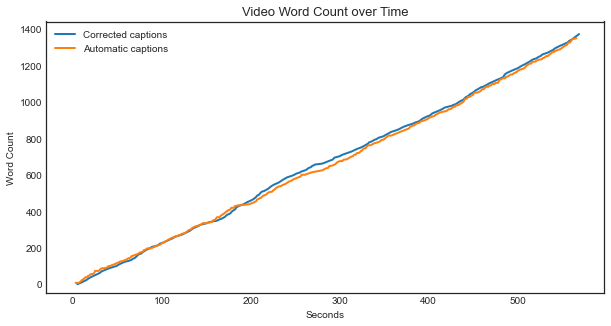

In [908]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
width = 2

ax.plot(humcc.word_count, linewidth=width)
ax.plot(autocc.word_count, linewidth=width)

ax.set_title('Video Word Count over Time', fontsize=13)
ax.set_xlabel('Seconds', fontsize = 10)
ax.set_ylabel('Word Count', fontsize = 10)

ax.set_xlim(-30)
ax.set_ylim(-50)

ax.legend(labels = ['Corrected captions', 
            'Automatic captions'])

plt.show()
fig.savefig('total_view.png')

After ca 3 minutes the audio was transcribed using more words than the automatically generated ones.

## WPM and CPS

In [909]:
humcc_wpm =  round(get_wpm(humcc))
autocc_wpm =  round(get_wpm(autocc))

humcc_cps = round(humcc_wpm * 5.0 / 60.00) #converting wpm into cps
autocc_cps = round(autocc_wpm * 5.0 / 60.0)

In [910]:
print("Corrected captions display {} wpm and {} cps".format(humcc_wpm, humcc_cps))
print("Automatic captions display {} wpm and {} cps".format(autocc_wpm, autocc_cps))

Corrected captions display 145 wpm and 12 cps
Automatic captions display 143 wpm and 12 cps


### WPM Plot

In [911]:
vector = [autocc_wpm, humcc_wpm]

names = ['Automatic captions',
        'Corrected captions']

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a1c70aa30>,
 [Text(0, 0, 'Automatic captions'), Text(1, 0, 'Corrected captions')])

Text(0.5, 1.0, 'Average words per minute')

Text(0.5, 0, 'Caption type')

Text(0, 0.5, 'Words per minute')

(0.5, 152.25)

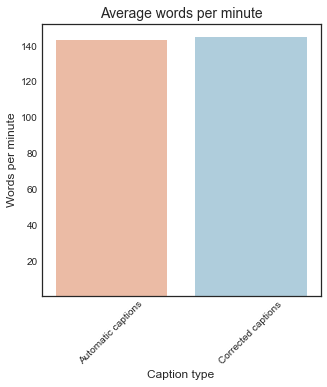

In [912]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Average words per minute', fontsize=14)
plt.xlabel('Caption type', fontsize=12)
plt.ylabel('Words per minute', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()
fig.savefig('average_wpm.png')

### CPS Plot

In [913]:
vector = [autocc_cps, humcc_cps]

names = ['Automatic captions',
        'Corrected captions']

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a1a4afd00>,
 [Text(0, 0, 'Automatic captions'), Text(1, 0, 'Corrected captions')])

Text(0.5, 1.0, 'Average characters per seconds')

Text(0.5, 0, 'Caption type')

Text(0, 0.5, 'Characters per Second')

(0.5, 12.6)

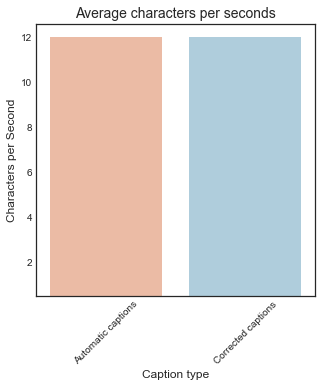

In [914]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Average characters per seconds', fontsize=14)
plt.xlabel('Caption type', fontsize=12)
plt.ylabel('Characters per Second', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()
fig.savefig('average_wps.png')

## ASR EVALUATION

### Imports

In [915]:
from jiwer import wer
import nltk
import jiwer
from nltk.corpus import wordnet, stopwords
import collections
import contractions 
import num2words
from string import punctuation

### Functions

In [916]:
def normalisation(file_path):

    with open(file_path, "r") as file: 
        lines = file.read()
        lines = re.sub(r"\b[A-Z]{3,}\b", "", lines) #removing uppercase words
        
        my_punctuation = punctuation.replace("'", "") #removing punctuation except for apostrophe
        text = lines.translate(str.maketrans("", "", my_punctuation))
        text = " ".join(re.split(r"\W+", text))

        
    return text.lower()

In [917]:
def content(file_path):
    """This function filters out 
    function words and keeps only content words"""
    
    file = normalisation(file_path)
    
    lemmatizer = nltk.WordNetLemmatizer()
        
    is_content = lambda pos: pos[:2] in ["NN", "ADJ", "ADV", "VERB"]
        
    clean = [lemmatizer.lemmatize(word) for (word, pos) 
                                 in nltk.pos_tag(nltk.word_tokenize(file)) if is_content(pos)]
    
    clean = " ".join([word for word in clean if len(word) > 3 
                      and word not in ["whoa", "yeah", "okay", "well"]])
    
    clean = " ".join([word for word in re.split(r"\W+", clean)])
    
    return clean

### WER, MER, WIL, WIP

In [918]:
ref = normalisation("ref.txt")
hyp1 = normalisation("hum.txt")
hyp2 = normalisation("auto.txt")

### Reference vs corrected captions

In [919]:

measures1 = jiwer.compute_measures(ref, hyp1)

print("{0:15}  {1}".format('N reference:', count_words(ref)))
print("{0:15}  {1}".format('N hypothesis:', count_words(hyp1)))

print( )

for measure, val in measures1.items():
    if measure in ["wer", "mer", "wil", "wip"]:
        print("{0:15}  {1}%".format(measure, round(val*100)))
    else:
        print("{0:15}  {1}%".format(measure, round(val / count_words(ref)*100)))


N reference:     1691
N hypothesis:    1542

wer              15%
mer              15%
wil              20%
wip              80%
hits             86%
substitutions    5%
deletions        10%
insertions       1%


In [920]:
vector = [val for measure, val in measures1.items() 
          if measure not in ["wer", "mer", "wil", "wip"]]

names = ["hits", "subs", "del", "ins"]

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a1c794a90>,
 [Text(0, 0, 'hits'),
  Text(1, 0, 'subs'),
  Text(2, 0, 'del'),
  Text(3, 0, 'ins')])

Text(0.5, 1.0, 'Corrected transcription')

Text(0.5, 0, 'Measures')

Text(0, 0.5, 'Number of words')

(0.5, 1518.3)

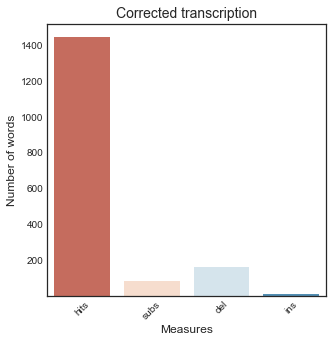

In [921]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Corrected transcription', fontsize=14)
plt.xlabel('Measures', fontsize=12)
plt.ylabel('Number of words', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()

### Reference vs aumated captions

In [922]:

measures2 = jiwer.compute_measures(ref, hyp2)

print("{0:15}  {1}".format('N reference:', count_words(ref)))
print("{0:15}  {1}".format('N hypothesis:', count_words(hyp2)))

print( )

for measure, val in measures2.items():
    if measure in ["wer", "mer", "wil", "wip"]:
        print("{0:15}  {1}%".format(measure, round(val*100)))
    else:
        print("{0:15}  {1}%".format(measure, round(val / count_words(ref)*100)))


N reference:     1691
N hypothesis:    1667

wer              7%
mer              7%
wil              10%
wip              90%
hits             94%
substitutions    4%
deletions        2%
insertions       1%


In [923]:
vector = [val for measure, val in measures2.items() 
          if measure not in ["wer", "mer", "wil", "wip"]]

names = ["hits", "subs", "del", "ins"]

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a1a4a4fd0>,
 [Text(0, 0, 'hits'),
  Text(1, 0, 'subs'),
  Text(2, 0, 'del'),
  Text(3, 0, 'ins')])

Text(0.5, 1.0, 'Automatic transcription')

Text(0.5, 0, 'Measures')

Text(0, 0.5, 'Number of words')

(0.5, 1669.5)

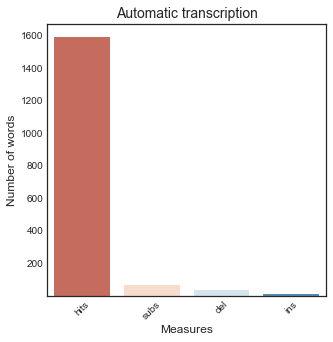

In [924]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Automatic transcription', fontsize=14)
plt.xlabel('Measures', fontsize=12)
plt.ylabel('Number of words', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()

## Evaluation on content words only

In [925]:
ref = content("ref.txt")
hyp1 = content("hum.txt")
hyp2 = content("auto.txt")

### Reference vs corrected captions

In [926]:
measures3 = jiwer.compute_measures(ref, hyp1)

print("{0:15}  {1}".format('N reference:', count_words(ref)))
print("{0:15}  {1}".format('N hypothesis:', count_words(hyp1)))

print( )

for measure, val in measures3.items():
    if measure in ["wer", "mer", "wil", "wip"]:
        print("{0:15}  {1}%".format(measure, round(val*100)))
    else:
        print("{0:15}  {1}%".format(measure, round(val / count_words(ref)*100)))


N reference:     253
N hypothesis:    254

wer              11%
mer              10%
wil              14%
wip              86%
hits             93%
substitutions    4%
deletions        3%
insertions       4%


In [933]:
vector = [val for measure, val in measures3.items() 
          if measure not in ["wer", "mer", "wil", "wip"]]

names = ["hits", "subs", "del", "ins"]

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a192a37f0>,
 [Text(0, 0, 'hits'),
  Text(1, 0, 'subs'),
  Text(2, 0, 'del'),
  Text(3, 0, 'ins')])

Text(0.5, 1.0, 'Corrected transcription')

Text(0.5, 0, 'Measures')

Text(0, 0.5, 'Number of words')

(0.5, 216.3)

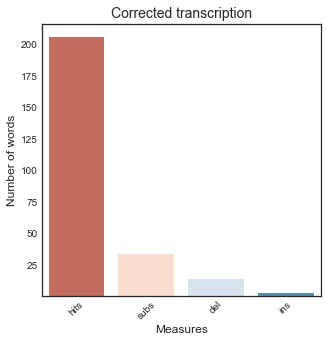

In [937]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Corrected transcription', fontsize=14)
plt.xlabel('Measures', fontsize=12)
plt.ylabel('Number of words', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()

In [927]:
measures4 = jiwer.compute_measures(ref, hyp2)

print("{0:15}  {1}".format('N reference:', count_words(ref)))
print("{0:15}  {1}".format('N hypothesis:', count_words(hyp2)))

print( )

for measure, val in measures4.items():
    if measure in ["wer", "mer", "wil", "wip"]:
        print("{0:15}  {1}%".format(measure, round(val*100)))
    else:
        print("{0:15}  {1}%".format(measure, round(val / count_words(ref)*100)))


N reference:     253
N hypothesis:    242

wer              20%
mer              20%
wil              31%
wip              69%
hits             81%
substitutions    13%
deletions        6%
insertions       1%


In [935]:
vector = [val for measure, val in measures4.items() 
          if measure not in ["wer", "mer", "wil", "wip"]]

names = ["hits", "subs", "del", "ins"]

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f9a2fd73220>,
 [Text(0, 0, 'hits'),
  Text(1, 0, 'subs'),
  Text(2, 0, 'del'),
  Text(3, 0, 'ins')])

Text(0.5, 1.0, 'Automatic transcription')

Text(0.5, 0, 'Measures')

Text(0, 0.5, 'Number of words')

(0.5, 216.3)

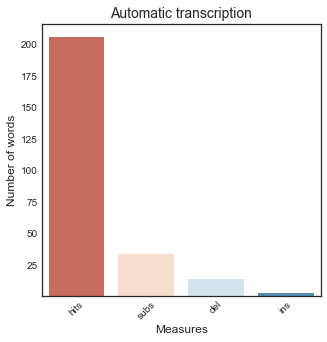

In [936]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Automatic transcription', fontsize=14)
plt.xlabel('Measures', fontsize=12)
plt.ylabel('Number of words', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()

In [928]:
ref = sorted(collections.Counter([w for w in re.split(r"\W+", ref)]))
hyp1 = sorted(collections.Counter([w for w in re.split(r"\W+", hyp1)]))
hyp2 = sorted(collections.Counter(([w for w in re.split(r"\W+", hyp2)])))

print("Reference\t\tCorrected\t\tAutomatic")
print("{:^10}\t\t{:^10}\t\t{:^10}".format(len(ref),len(hyp1),len(hyp2)))
print(60*"=")
print()
for w1, w2, w3 in zip(ref, hyp1, hyp2):
        print('{:^10}\t\t{:^10}\t\t{:^10}'
              .format(w1, w2, w3))

Reference		Corrected		Automatic
   109    		   109    		   109    

 absence  		 absence  		 absence  
  affix   		  affix   		  affix   
  africa  		  africa  		  africa  
 african  		 african  		 african  
 anybody  		 anything 		 anybody  
 anything 		 archival 		 anything 
 archival 		   area   		 archival 
 argument 		 argument 		 argument 
   asia   		   asia   		   asia   
attention 		attention 		attention 
background		background		background
 barrier  		 barrier  		 barrier  
   bell   		   bell   		   bell   
   bias   		   bias   		   bias   
bickerton 		bickerton 		bickerton 
 business 		 business 		biggerton 
candidate 		candidate 		 bikerton 
  child   		  child   		 business 
  china   		  china   		candidate 
  choice  		  choice  		  career  
  claim   		  claim   		  child   
  coast   		  coast   		  china   
   code   		   code   		  choice  
communication		communication		  claim   
community 		community 		  coast   
complexity		complexity		   code   
 concern  		 con

In [945]:
ref_vs_corr = 0
ref_vs_auto = 0

for w1, w2, w3 in zip(ref, hyp1, hyp2):
    if w1 != w2 :
        ref_vs_corr += 1
    elif w1 != w3:
        ref_vs_auto += 1
        
        
print("The corrected transcription differs from reference for {} lemmas"
      .format(ref_vs_corr))
print("The automated transcription differs from reference for {} lemmas"
      .format(ref_vs_auto))


The corrected transcription differs from reference for 38 lemmas
The automated transcription differs from reference for 48 lemmas


## Semantic distance

### References

Briggs, J. (2021) BERT For Measuring Text Similarity. High-performance semantic similarity with BERT. Towards Data Science. 05/05/2021

https://towardsdatascience.com/bert-for-measuring-text-similarity-eec91c6bf9e1
https://github.com/jamescalam/transformers/blob/main/course/similarity/04_sentence_transformers.ipynb

Onofrey, E. (2019) Analyzing Movie Dialog Speed with Python. Towards Data Science. 10/09/2019

https://towardsdatascience.com/analyzing-movie-dialog-speed-with-python-79a8a8a286e8

https://github.com/eonofrey/movie_word_counts

